In [1]:
import os
import rpy2
import torch
import anndata
import logging
import warnings
import anndata2ri
import matplotlib
import liana as li
import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sb
import cell2cell as c2c
import plotnine as p9
from rpy2.robjects import r
from anndata import AnnData
from tabnanny import verbose
from collections import defaultdict
import matplotlib.pyplot as plt
from os import PathLike, fspath
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from matplotlib.pyplot import rcParams
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import train_test_split
from rpy2.robjects.conversion import localconverter

In [2]:
def get_sys_dpi(width, height, diag):
    '''
    obtain dpi of system
    
    w: width in pixels (if unsure, go vist `whatismyscreenresolution.net`)
    h: height in pixels
    d: diagonal in inches
    '''
    w_inches = (diag**2/ (1 + height**2/width**2))**0.5
    return round(width/w_inches)

In [3]:
%%R
suppressPackageStartupMessages({
    library(reticulate)
    library(ggplot2)
    library(tidyr)
    library(dplyr)
    library(purrr)
    library(tibble)
})


UsageError: Cell magic `%%R` not found.


In [4]:
# # Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# # Automatically convert rpy2 outputs to pandas dataframes
# pandas2ri.activate()
# anndata2ri.activate()
# %load_ext rpy2.ipython

warnings.filterwarnings("ignore", category=PendingDeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

rcParams['figure.dpi'] = get_sys_dpi(1512, 982, 14.125)
#rcParams['figure.figsize']=(4,4) #rescale figures

sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()



-----
anndata     0.8.0
scanpy      1.9.1
-----
OpenSSL                                     22.0.0
PIL                                         9.2.0
aa8f2297d25b4dc6fd3d98411eb3ba53823c4f42    NA
absl                                        NA
adjustText                                  NA
anndata2ri                                  1.1
appnope                                     0.1.2
asttokens                                   NA
astunparse                                  1.6.3
attr                                        21.4.0
backcall                                    0.2.0
beta_ufunc                                  NA
binom_ufunc                                 NA
boto3                                       1.26.32
botocore                                    1.29.32
bottleneck                                  1.3.5
brotli                                      NA
cell2cell                                   0.6.6
certifi                                     2022.09.24
cffi          

## Table of contents:

  * <a href=#Reading>1. Reading in the data</a>
  * <a href=#Preprocessing>2. Cell-Cell Communication</a>

# 1. Reading in the data

### [Mathys et. al. 2019](https://doi.org/10.1038/s41586-019-1195-2) (Prefrontal Cortex)

Now, we load the preprocessed and annotated data for downstream analysis.

In [5]:
save_prefix = 'allen_mtg'

adata_annot = sc.read_h5ad(f'../data/processed/{save_prefix}/{save_prefix}_mapped_anndata.h5ad')
adata_annot.obs_names_make_unique()
adata_annot.var_names_make_unique()
adata_annot.X = adata_annot.layers['counts'].copy()
adata_annot.obs['pathology.group']
del adata_annot.obsm, adata_annot.layers, adata_annot.varm, adata_annot.uns, adata_annot.obsp

In [6]:
# adata_annot.X = adata_annot.layers['counts'].toarray().copy()
sc.pp.normalize_total(adata_annot)
sc.pp.log1p(adata_annot)

normalizing counts per cell
    finished (0:00:02)


In [7]:
#adata_annot = adata_annot[:, adata_annot.var.highly_variable=="True"]
adata_annot

AnnData object with n_obs × n_vars = 104349 × 17950
    obs: 'ID', 'name', 'versionNumber', 'contentType', 'dataFileSizeBytes', 'createdBy', 'createdOn', 'modifiedBy', 'modifiedOn', 'parentId', 'synapseURL', 'dataFileMD5Hex', 'assay_x', 'consortium', 'dataSubtype', 'dataType', 'fileFormat', 'grant', 'individualID_x', 'isModelSystem', 'isMultiSpecimen', 'isMultiome', 'libraryPrep', 'nucleicAcidSource_x', 'organ_x', 'platform', 'readLength', 'resourceType', 'runType', 'sex_x', 'species_x', 'specimenID', 'study', 'tissue_x', 'path', 'error', 'individualID_y', 'specimenIdSource', 'organ_y', 'tissue_y', 'BrodmannArea', 'sampleStatus', 'tissueWeight', 'tissueVolume', 'nucleicAcidSource_y', 'cellType', 'fastingState', 'isPostMortem', 'samplingAge', 'samplingAgeUnits', 'visitNumber', 'assay_y', 'individualID', 'dataset', 'individualIdSource', 'species_y', 'sex_y', 'race', 'ethnicity', 'yearsEducation', 'ageDeath', 'causeDeath', 'mannerDeath', 'apoe4Status', 'apoeGenotype', 'pmi', 'pH', 'brainW

# 2 **Tensor Cell-2-Cell Communication**

## `Context-aware deconvolution of cell–cell communication with Tensor-cell2cell.`


**Summary**:

- We inherently assume that Intercellular communication changes as a function of the disease states. Therefore, By structuring cell-cell communication scores in the form of a tensor (a higher-order generalization of matrices) which explicitly includes contexts/disease states as one of its dimensions, we can employ tensor decomposition algorithms to recover these context-dependent communication patterns.

- From the previous analysis, we observed that although, the prioritized interactions by both `CellPhoneDB` and `LIANA` seem biologically-plausible and potentially relevant to the AD, it is challenging to ascertain their relevance and interprete their results.

- In particular, altough cell interactions determine phenotypes, and intercellular communication is shaped by cellular contexts such as disease state, organismal life stage, and tissue microenvironment. However, the methods we used either disregard cellular context or rely on simple pairwise comparisons between samples, thus limiting the ability to decipher complex cell–cell communication across multiple levels of disease severity/conditions.

- `Tensor-cell2cell`, presents an an unsupervised method using tensor decomposition, to `deciphers context-driven intercellular communication` by simultaneously accounting for multiple disease states. 

- To do so, Tensor-cell2cell uncovers context-driven patterns of communication associated with different phenotypic states and determined by unique combinations of cell types and ligand-receptor pairs. 

- As such, Tensor-cell2cell robustly improves upon and extends the analytical capabilities of existing tools.

## 2.1 **Background**

Tensor decomposition of cell-cell communication patterns, as proposed by [**Armingol and Baghdassarian et al. 2022**](https://www.nature.com/articles/s41467-022-31369-2), enables us to decipher context-driven intercellular communication by simultaneously accounting for an unlimited number of “contexts”. These contexts in our case represents samples coming from multiple conditions.

The power of `Tensor-cell2cell` is in its ability to decompose latent patterns of intercellular communication in an untargeted manner, in theory being able to handle cell-cell communication results coming from any experimental design, regardless of its complexity.

Simply put, `tensor_cell2cell uses LIANA’s output by sample to build a 4D tensor, represented by`:

- `Contexts`,

- `Interactions`

- `Sender`, and 

- `Receiver cell types`.

This tensor is then decomposed into a set of factors, which can be interpreted as low-dimensionality latent variables (vectors) that capture the CCC patterns across contexts.

Here, we will combine LIANA with tensor_cell2cell to decipher potential ligand-receptor interaction changes in AD.



## 2.2 **Motivation**

From the differential pathway analysis, we observe that certain pathways that are specific to some cell-types are instead differentially perturbed in other cell-types. This could be arise from cell autonomous processes or from more complex mechanisms involving paracrine signalling from other cell types. To accurately delineate this, we perform cell-cell communication analysis in this study using the procedures described in [**Single-cell Best Practices**](https://www.sc-best-practices.org/mechanisms/cell_cell_communication.html)

## 2.3. **Methods**

Before we decompose the CCC patterns across contexts/samples with tensor_cell2cell, we need to run liana on each condition. 

This is because `tensor_cell2cell uses LIANA’s output by condition to build a 4D tensor, that is later decomposed into CCC patterns`. To do so, liana provides a utility function called by_sample that runs each method in LIANA on each sample within the AnnData object, and returns a long-format pandas.DataFrame with the results.

### 2.3.1 **Ligand-Receptor Inference by Sample with `LIANA`**

Although, the prioritized interactions by both CellPhoneDB and LIANA seem biologically-plausible and potentially relevant to the AD, it is challenging to ascertain their relevance. 

In particular, the advantage of these methods to generate systems-level insights in a hypothesis-free manner happens to also be one of their major disadvantages. `Specifically because ligand-receptor tools return all plausible ligand-receptor interactions for every pair of cell types, thus we end up with huge lists of interactions`, and choosing targets for subsequent experimental validation can be challenging.

Thus, we perform `Ligand-Receptor Inference by Sample`


In [8]:
li.method.show_methods()

,Method Name,Magnitude Score,Specificity Score,Reference
0,CellPhoneDB,lr_means,cellphone_pvals,"Efremova, M., Vento-Tormo, M., Teichmann, S.A...."
0,Connectome,expr_prod,scaled_weight,"Raredon, M.S.B., Yang, J., Garritano, J., Wang..."
0,log2FC,None,lr_logfc,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,NATMI,expr_prod,spec_weight,"Hou, R., Denisenko, E., Ong, H.T., Ramilowski,..."
0,SingleCellSignalR,lrscore,None,"Cabello-Aguilar, S., Alame, M., Kon-Sun-Tack, ..."
0,CellChat,lr_probs,cellchat_pvals,"Jin, S., Guerrero-Juarez, C.F., Zhang, L., Cha..."
0,Rank_Aggregate,magnitude_rank,specificity_rank,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,Geometric Mean,lr_gmeans,gmean_pvals,CellPhoneDBv2's permutation approach applied t...


In [10]:
sample_key = 'individualID'
condition_key = 'pathology.group'
groupby = 'cell_type'

In [10]:
# adata_annot.obs.cell_type.value_counts(normalize=True)

# strata = adata_annot.obs['pathology.group']

# adata_train, adata_test = train_test_split(adata_annot, test_size=0.7, train_size=None, random_state=None,
#                                             shuffle=True, stratify=strata)

# adata_test.obs.cell_type.value_counts(normalize=True)

In [11]:
li.method.rank_aggregate.by_sample(adata_annot,
                                   groupby=groupby, 
                                   sample_key=sample_key, # sample key by which we which to loop 
                                   use_raw=False, verbose=True, # use 'full' to show all information
                                   n_perms=100, # reduce number of permutations for speed
                                   return_all_lrs=True, # return all LR values
                                   )

Now running: H20.33.020:   0%|          | 0/8 [00:00<?, ?it/s]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: H20.33.044:  12%|█▎        | 1/8 [01:01<07:11, 61.64s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: H21.33.003:  25%|██▌       | 2/8 [02:13<06:44, 67.39s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: H21.33.004:  38%|███▊      | 3/8 [03:31<06:01, 72.23s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: H21.33.005:  50%|█████     | 4/8 [04:50<05:00, 75.05s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: H21.33.009:  62%|██████▎   | 5/8 [05:41<03:19, 66.40s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: H21.33.023:  75%|███████▌  | 6/8 [06:34<02:03, 61.79s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: H21.33.044:  88%|████████▊ | 7/8 [07:51<01:06, 66.98s/it]

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Now running: H21.33.044: 100%|██████████| 8/8 [08:28<00:00, 63.54s/it]


Let’s examine the output from the `tensor_cell2cell` method

In [12]:
adata_annot.uns["liana_res"].sort_values(by='specificity_rank').head()

,individualID,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,lr_probs,cellchat_pvals,steady_rank,specificity_rank,magnitude_rank
585,H20.33.020,Endothelial,Microglia,DCN,TLR2,2.131053,0.0,4.522796,5.893362,3.982836,0.932440,0.886481,0.172421,0.0,9.284560e-12,3.868690e-12,0.000006
1481905,H21.33.044,Oligodendrocyte,Microglia,CD22,PTPRC,2.172838,0.0,4.437381,5.042189,3.584907,0.924955,0.890366,0.169578,0.0,1.793885e-11,7.474816e-12,0.000006
1269028,H21.33.023,Endothelial,Microglia,DCN,TLR2,1.703786,0.0,2.882659,6.024059,3.405109,0.896837,0.851511,0.117981,0.0,5.063228e-11,2.109797e-11,0.000059
854934,H21.33.005,Endothelial,Microglia,DCN,TLR2,1.715391,0.0,2.815945,6.581313,3.380715,0.942691,0.856119,0.116965,0.0,1.663742e-10,6.932839e-11,0.000065
425581,H21.33.003,Endothelial,Microglia,DCN,TLR2,1.877149,0.0,3.267053,5.389154,3.598132,0.869650,0.857618,0.144340,0.0,9.413804e-10,3.923003e-10,0.000025


### **Visual exploration**

Now that we have obtained results by sample, we can use a dotplot by sample to visualize the ligand-receptor interactions. Let’s pick arbitrarily the interactions with the highest magnitude_rank.

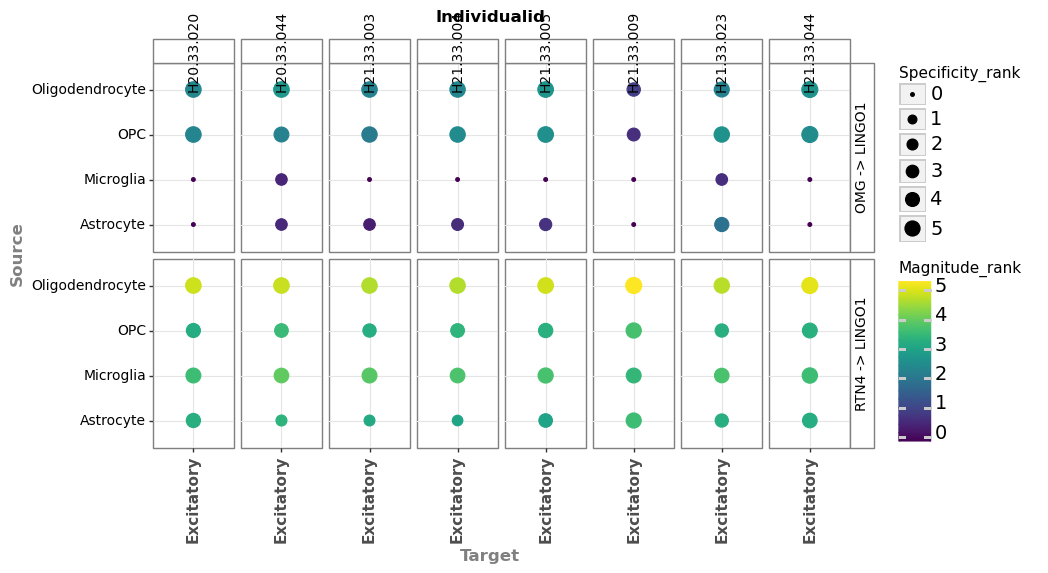

<ggplot: (877657893)>

In [13]:
(li.pl.dotplot_by_sample(adata_annot, sample_key=sample_key,
                        colour="magnitude_rank", size="specificity_rank",
                        source_labels=["Astrocyte", "Microglia", "Oligodendrocyte", "OPC"],
                        target_labels=["Excitatory"],
                        ligand_complex=["OMG", "RTN4"],
                        receptor_complex=["LINGO1"],
                        inverse_colour=True,
                        inverse_size=True,
                        figure_size=(9, 5),
                        size_range=(1, 6),
) +
 # rotate facet labels
 p9.theme(strip_text=p9.element_text(size=10, colour="black", angle=90))
 )

We highlight the receptor-ligand pairs and related pathways involving LINGO1 and its ligands, OMG and RTN4, and their potential role in Alzheimer's disease (AD). Our interest in LINGO1 stems from previous reports by Hansruedi Mathys et al. (2019) which identified it as one of the top upregulated genes across multiple cell types involved in related processes. LINGO1 is a receptor that acts as a negative regulator of neuronal survival, axonal integrity, and oligodendrocyte differentiation and myelination.

### **Building a Tensor**

Even on a selected subset interactions and cell types, we can see that interpretation becomes challenging. To overcome this, we can use tensor_cell2cell to decompose the CCC patterns across contexts/samples.

Before we can decompose the tensor, we need to build it. To do so, we will use the `to_tensor_c2c` function from `liana`. This function takes as input the pandas.DataFrame with the results from `liana.by_sample`, and returns a `cell2cell.tensor.PrebuiltTensor object`. This object contains the tensor, as well as other useful utility functions.

Note that the way that we build the tensor can impact the results that we obtain. For more information, please refer to the tensor_cell2cell documentation, as well as the c2c.tensor.external_scores.dataframes_to_tensor function.

Tensor-cell2cell uncovers context-driven patterns of communication associated with different phenotypic states and determined by unique combinations of cell types and ligand-receptor pairs.

In [14]:
tensor = li.multi.to_tensor_c2c(adata_annot,
                                sample_key=sample_key,
                                score_key='magnitude_rank', # can be any score from liana
                                how='outer_cells' # how to join the samples
                                )

  0%|          | 0/8 [00:00<?, ?it/s]

We can check the shape of `the tensor, represented as (Contexts, Interactions/LR pairs, Senders, Receivers).`

In [15]:
tensor.shape

(8, 4032, 7, 7)

One can save the tensor to disk, by using the `c2c.io.export_variable_with_pickle` function

In [16]:
c2c.io.export_variable_with_pickle(tensor, "../data/processed/ad_vs_no_c2c_tensor.pkl")

../data/processed/ad_vs_no_c2c_tensor.pkl  was correctly saved.


### **Building Metadata**

Now we generate a list containing metadata for each tensor order/dimension - Later used for coloring factor plots

This is a list containing metadata for each dimension of the tensor (contexts, LR pairs, sender cells, receiver cells). Each metadata corresponds to a dataframe with info of each element in the respective dimension.

In [17]:
context_dict = adata_annot.obs[[sample_key, condition_key]].drop_duplicates()
context_dict = dict(zip(context_dict[sample_key], context_dict[condition_key]))
context_dict = defaultdict(lambda: 'Unknown', context_dict)
#context_dict = dict(sorted(context_dict.items(), key=lambda item: item[1]))
tensor_meta = c2c.tensor.generate_tensor_metadata(interaction_tensor=tensor,
                                                  metadata_dicts=[context_dict, None, None, None],
                                                  fill_with_order_elements=True
                                                  )

### **Running Tensor-cell2cell**

#### **Elbow analysis for selecting Rank for Tensor-Factorization**

We could either select the number of factors to decompose CCC, manually or automatically from an Elbow analysis.

To do this manually, after running the Elbow analysis, one can manually selected the number of factors.

In this case, we change the parameter `automatic_elbow = True` to automatically select the number of factors.

`Here, the error measures how different is the original tensor from the sum of R rank-1 tensors used to approximate it. The idea is to find a good trade-off between a small number of factors and a small error.`

`Here, we omit this optimal rank estimation step, as the optimal rank has been precomputed. This is computationally intensive, and it is recommened to use a GPU for this step, by setting device=’cuda’, or alternatively Google Colab to run this step on the prebuilt Tensor.`

  0%|          | 0/25 [00:00<?, ?it/s]

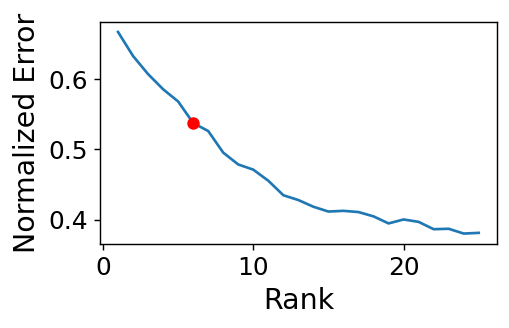

In [18]:
elbow, error = tensor.elbow_rank_selection(upper_rank=25,
                                           runs=1, # This can be increased for more robust results
                                           init='random',
                                           automatic_elbow=False,
                                           random_state=888,
                                          )

# If automatic_elbow=True, remove these two lines. To save the figure in that case,
# add the parameter filename=output_folder + 'Elbow.svg' in the previous function.
# The number of factors will be saved in tensor.rank

_ = plt.plot(*error[5], 'ro') # Here we selected a number of 6 factors.
plt.savefig('../results/ad_vs_no/tensor_c2c_' + 'Elbow.svg', dpi=300, bbox_inches='tight')
plt.show(block=False)

#### **Perform tensor factorization**


Next, `we apply a tensor decomposition`, specifically a non-negative canonical polyadic decomposition (CPD) (same performed in the elbow analysis. 

Briefly, tensor decomposition identifies a low-rank tensor (here, a rank of 6) that approximated the full tensor. `This low-rank tensor can be represented as the sum of a set of rank-1 tensors (20 of them in this case)`. 

Each rank-1 tensor represents a factor in the decomposition and can be further represented as the outer product of n vectors, where n represents the number of tensor dimensions. 

Each vector represents one of the n tensor dimensions for that factor and its values, corresponding to individual elements in each dimension, represent the factor loadings. 

`In our case, each factor will contain loadings for the context, LR pair, sender-cell, and receiver-cell dimensions. Those elements within each factor that contain high loadings contribute to the factor-specific communication pattern.`

Let’s now run the Tensor decomposition pipeline of Tensor-cell2cell. This function includes optimal rank estimation, as well as PARAFAC decomposition of the tensor.

In [19]:
tensor = c2c.analysis.run_tensor_cell2cell_pipeline(tensor,
                                                    tensor_meta,
                                                    copy_tensor=True, # Whether to output a new tensor or modifying the original
                                                    rank=20, # Number of factors to perform the factorization. If None, it is automatically determined by an elbow analysis. Here, it was precomuputed.
                                                    tf_optimization='regular', # To define how robust we want the analysis to be.
                                                    random_state=0, # Random seed for reproducibility
                                                    device='cpu', # Device to use. If using GPU and PyTorch, use 'cuda'. For CPU use 'cpu'
                                                    elbow_metric='error', # Metric to use in the elbow analysis.
                                                    smooth_elbow=False, # Whether smoothing the metric of the elbow analysis.
                                                    upper_rank=25, # Max number of factors to try in the elbow analysis
                                                    tf_init='random', # Initialization method of the tensor factorization
                                                    tf_svd='numpy_svd', # Type of SVD to use if the initialization is 'svd'
                                                    cmaps=None, # Color palettes to use in color each of the dimensions. Must be a list of palettes.
                                                    sample_col='Element', # Columns containing the elements in the tensor metadata
                                                    group_col='Category', # Columns containing the major groups in the tensor metadata
                                                    output_fig=False, # Whether to output the figures. If False, figures won't be saved a files if a folder was passed in output_folder.
                                                    )

Device is either not available or the backend used with tensorly does not support this device.                   Try changing it with tensorly.set_backend("<backend_name>") before.
Running Tensor Factorization


#### **Plot Factor Loadings**


After performing the tensor factorization/decomposition, a set of loadings is obtained in a factor-specific way. These loadings provide details of what elements of each dimension are important within each factor.

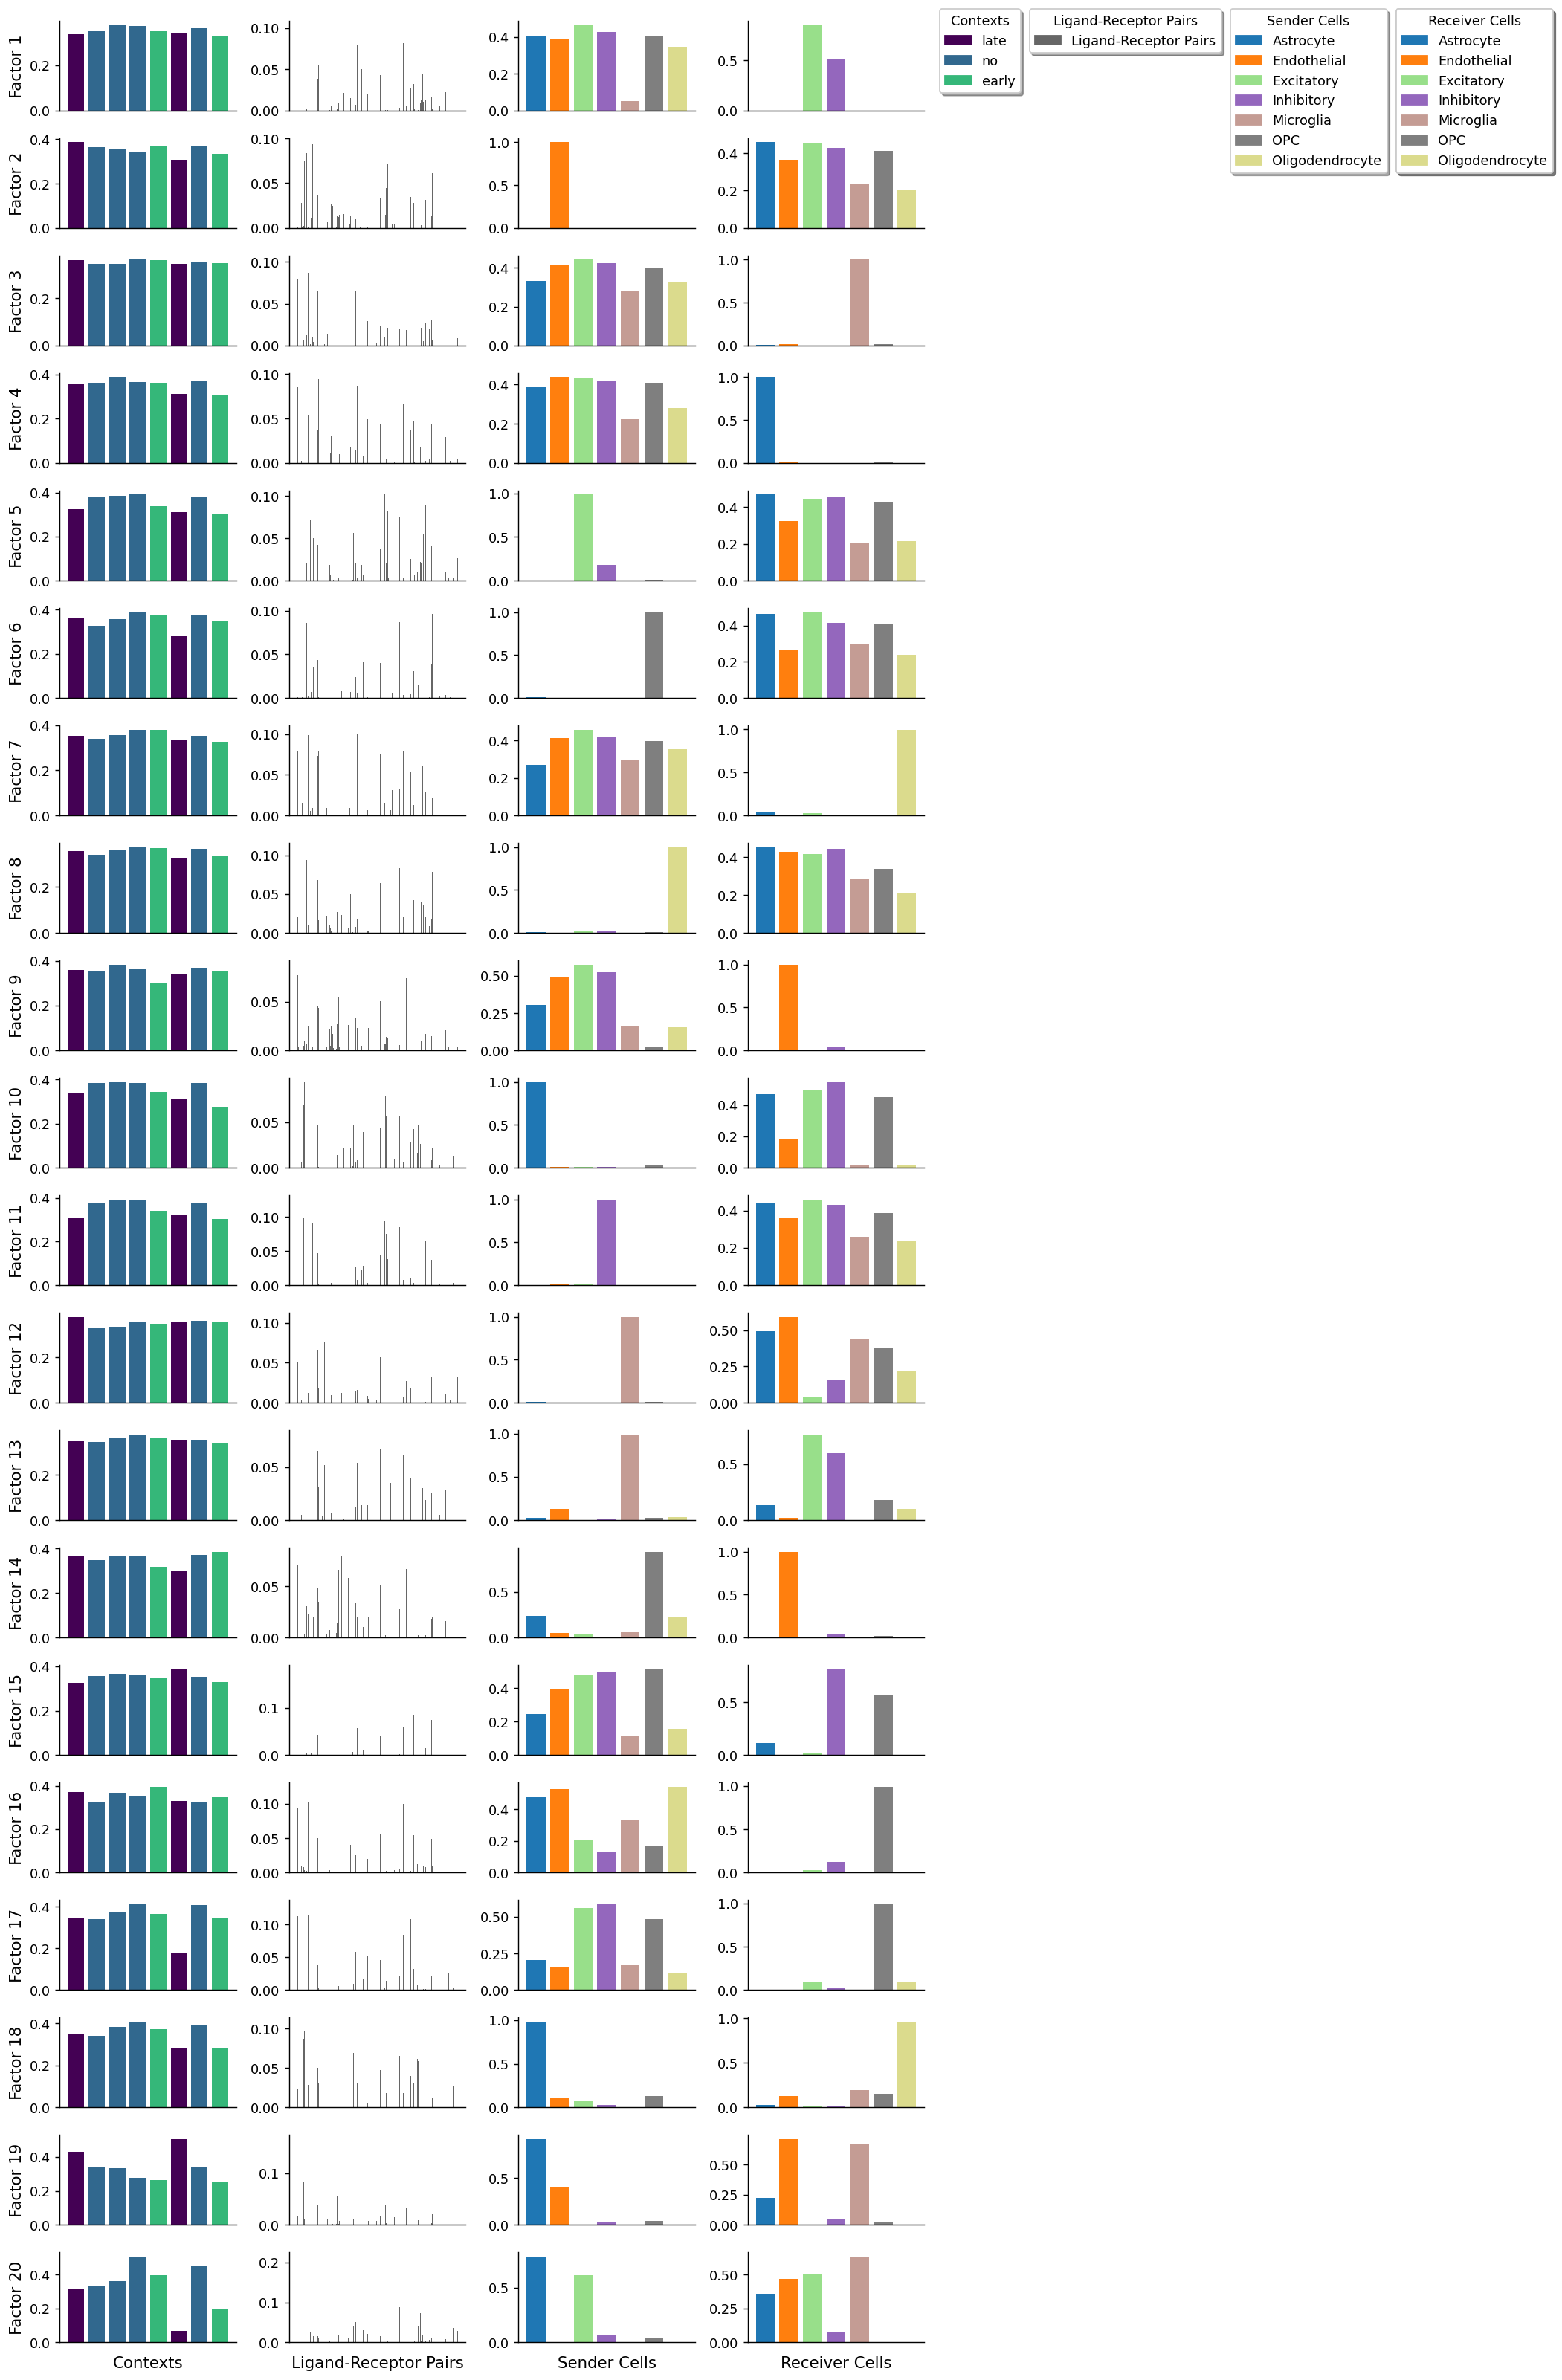

In [20]:
figures, axes = c2c.plotting.tensor_factors_plot(interaction_tensor=tensor,
                                                 metadata = tensor_meta, # This is the metadata for each dimension
                                                 sample_col='Element',
                                                 group_col='Category',
                                                 meta_cmaps = ['viridis', 'Dark2_r', 'tab20', 'tab20'],
                                                 fontsize=10, # Font size of the figures generated
                                                 )
plt.show()

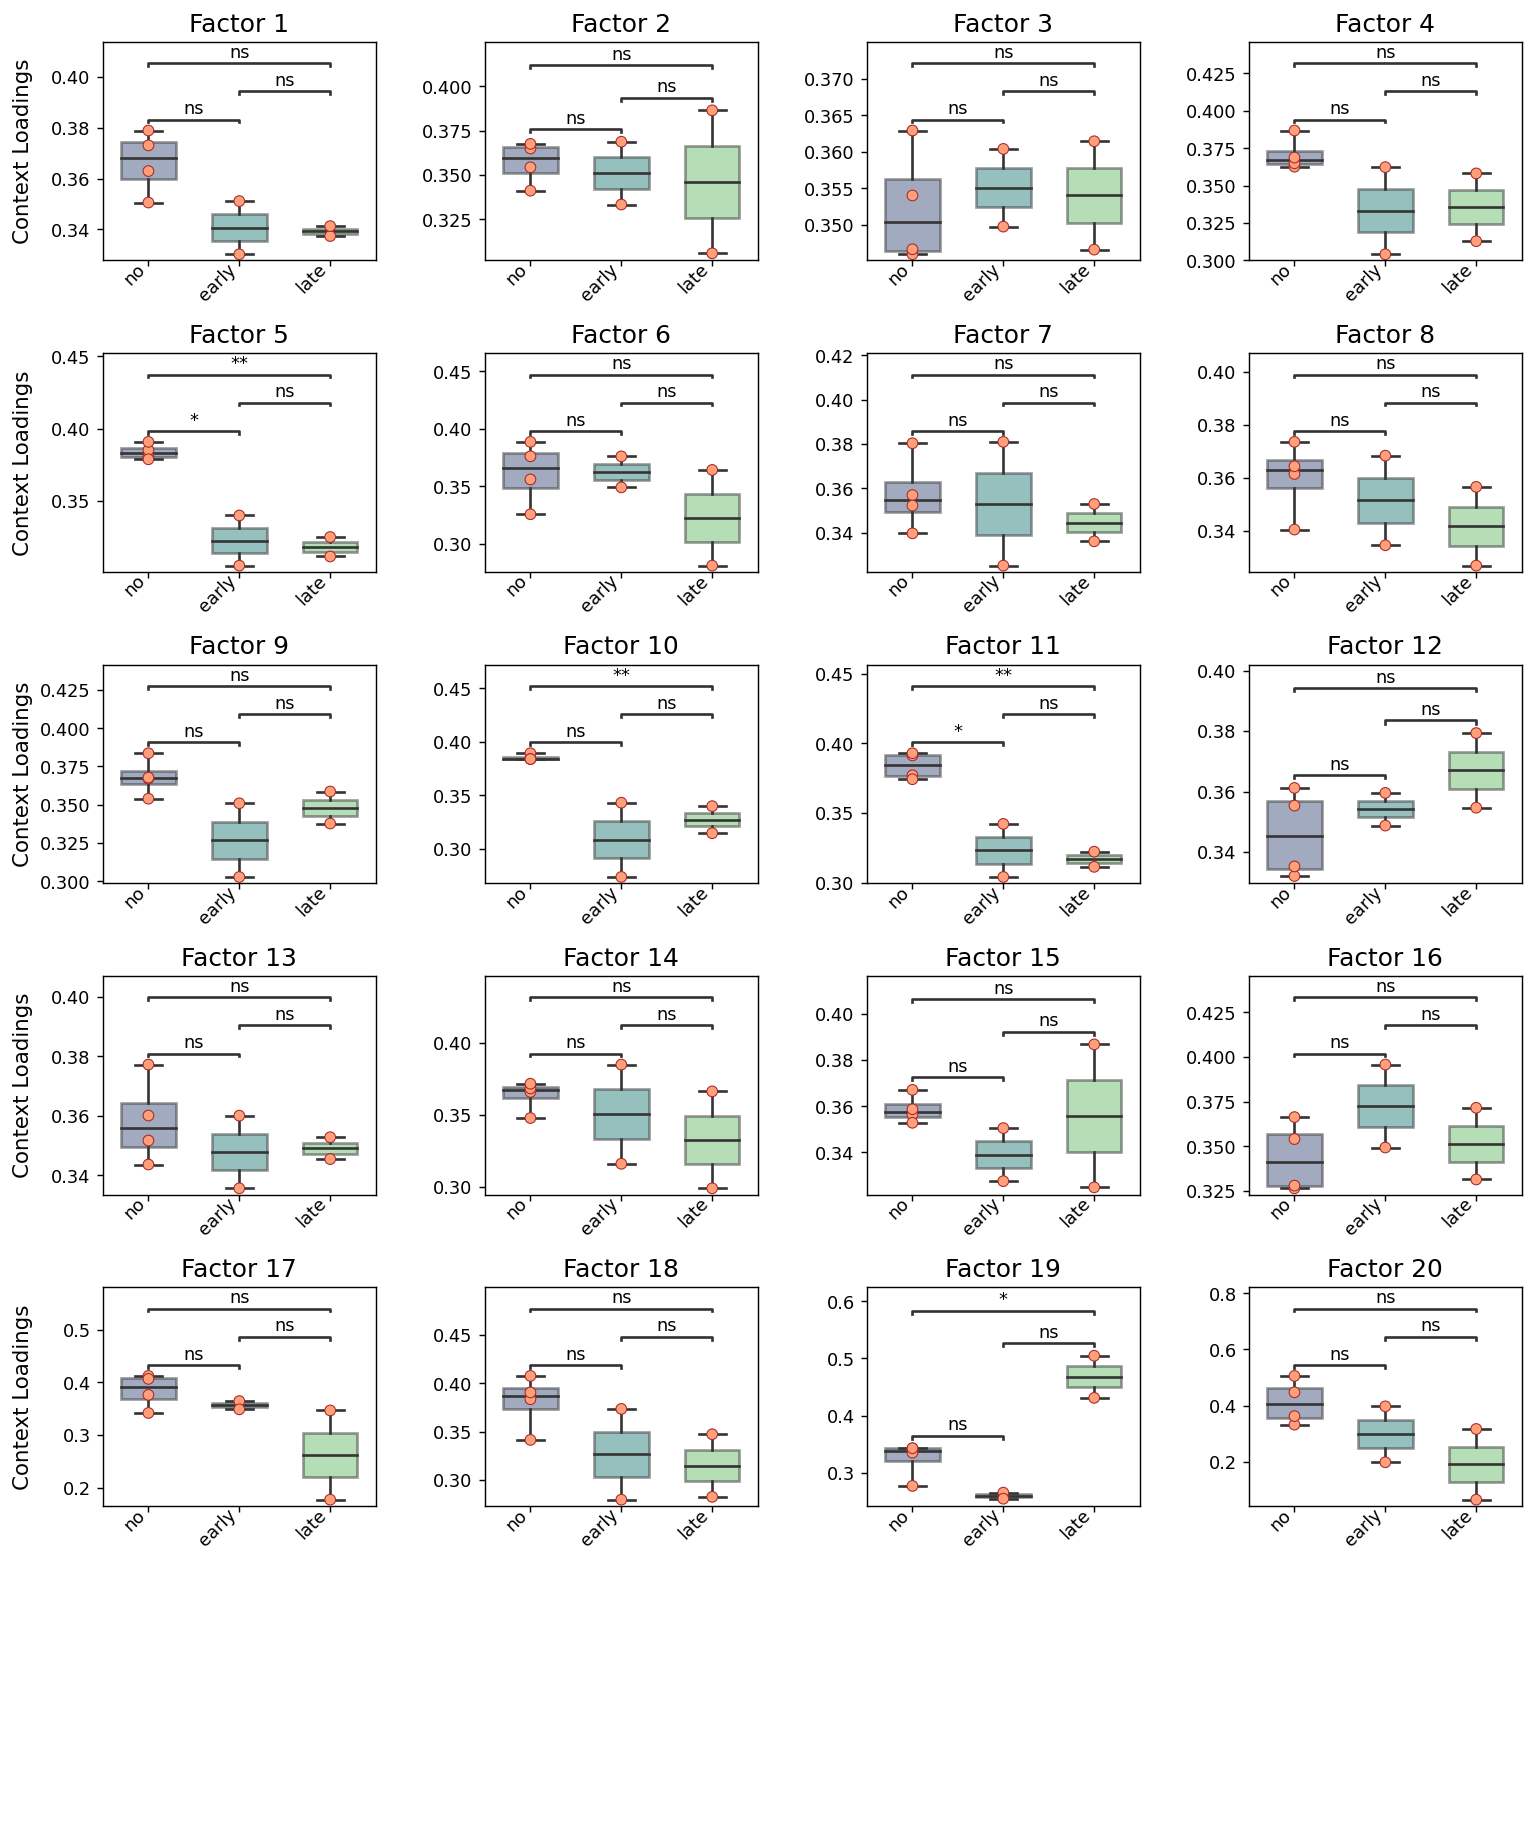

In [23]:
factors = tensor.factors
boxplot, _ = c2c.plotting.factor_plot.context_boxplot(factors['Contexts'],
                                                   metadict=context_dict,
                                                   nrows=6,
                                                   figsize=(12, 15),
                                                   group_order=['no', 'early', 'late'],
                                                   statistical_test='t-test_ind',
                                                   pval_correction='bonferroni',
                                                   cmap='viridis',
                                                   verbose=False,
                                                   # filename=output_folder + 'Sample-Boxplots.svg'
                                                  )
plt.show()

In [24]:
tensor.export_factor_loadings('../results/ad_vs_no/tensor_c2c_factor_no_norm_' + 'Loadings.xlsx')

Loadings of the tensor factorization were successfully saved into ../results/ad_vs_no/tensor_c2c_factor_no_norm_Loadings.xlsx


Each factor represents a context-dependent communication pattern. 

In this visualization, each row is a factor and each column is a tensor dimension in that factor (contexts, LR pairs, sender-cells, or receiver-cells). 

The loadings represent the contribution of each element to that pattern, and their combinations between all four dimensions represent the overall pattern. 

For example, in Factor 3, the identified communication pattern is stronger for Control rather than ASD patients, represented by the overall loading values of each group. Amongst the LR pairs with high loadings, L5/6-CC and L2/3 contribute most strongly to sending the communicatory signal (i.e., ligand expression) whereas there is a relatively uniform distribution of cells receiving the signal (i.e., for the receptors that correspond to highly expressed ligands, all cells have similar receptor expression).

In [25]:
factors = c2c.io.load_tensor_factors('../results/ad_vs_no/tensor_c2c_factor_no_norm_' + 'Loadings.xlsx')

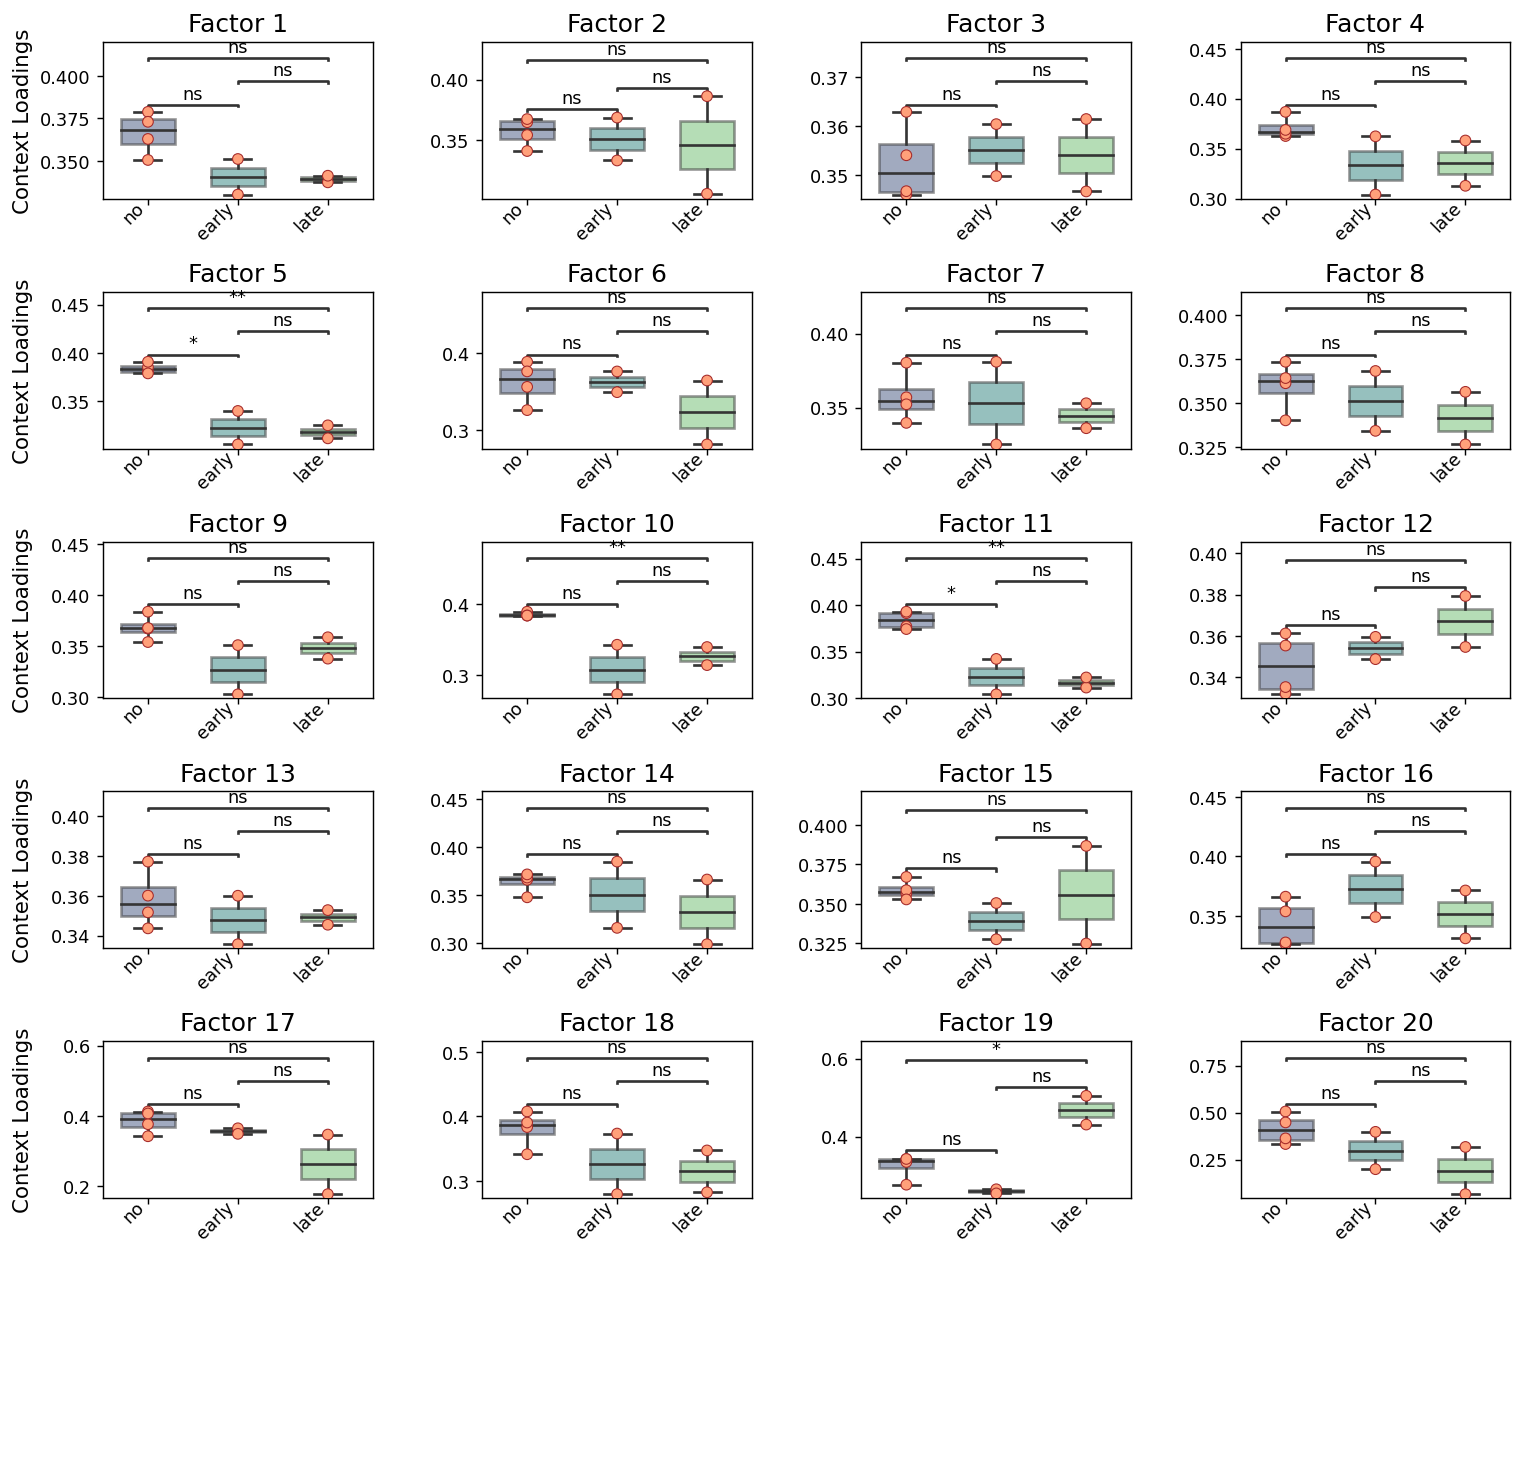

In [26]:
boxplot = c2c.plotting.factor_plot.context_boxplot(factors['Contexts'],
                                                   metadict=context_dict,
                                                   nrows=6,
                                                   figsize=(12, 12),
                                                   group_order=['no', 'early', 'late'],
                                                   statistical_test='t-test_ind',
                                                   pval_correction='bonferroni',
                                                   cmap='viridis',
                                                   verbose=False,
                                                   #filename=output_folder + 'Sample-Boxplots.svg'
                                                  )

plt.show()

In [27]:
networks = c2c.analysis.tensor_downstream.get_factor_specific_ccc_networks(factors, 
                                                                           sender_label='Sender Cells',
                                                                           receiver_label='Receiver Cells')

In [28]:
network_by_factors = c2c.analysis.tensor_downstream.flatten_factor_ccc_networks(networks, orderby='receivers')

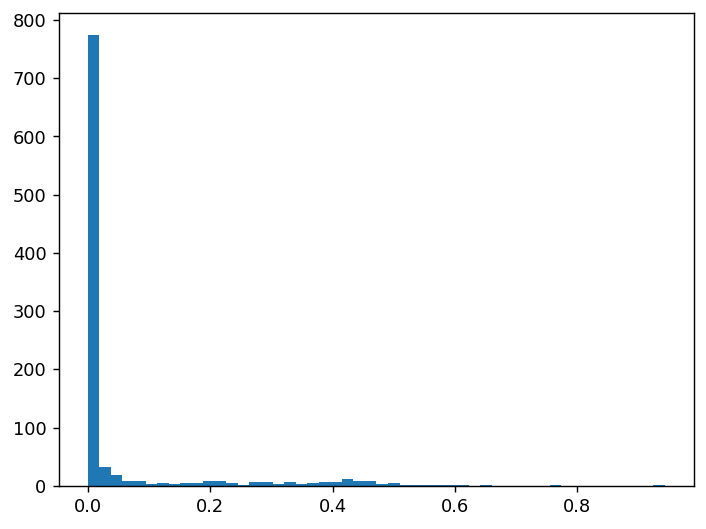

In [29]:
_ = plt.hist(network_by_factors.values.flatten(), bins = 50)
plt.show()

In [30]:
# To consider only cells with high potential to interact in each factor
ccc_threshold = 0.075

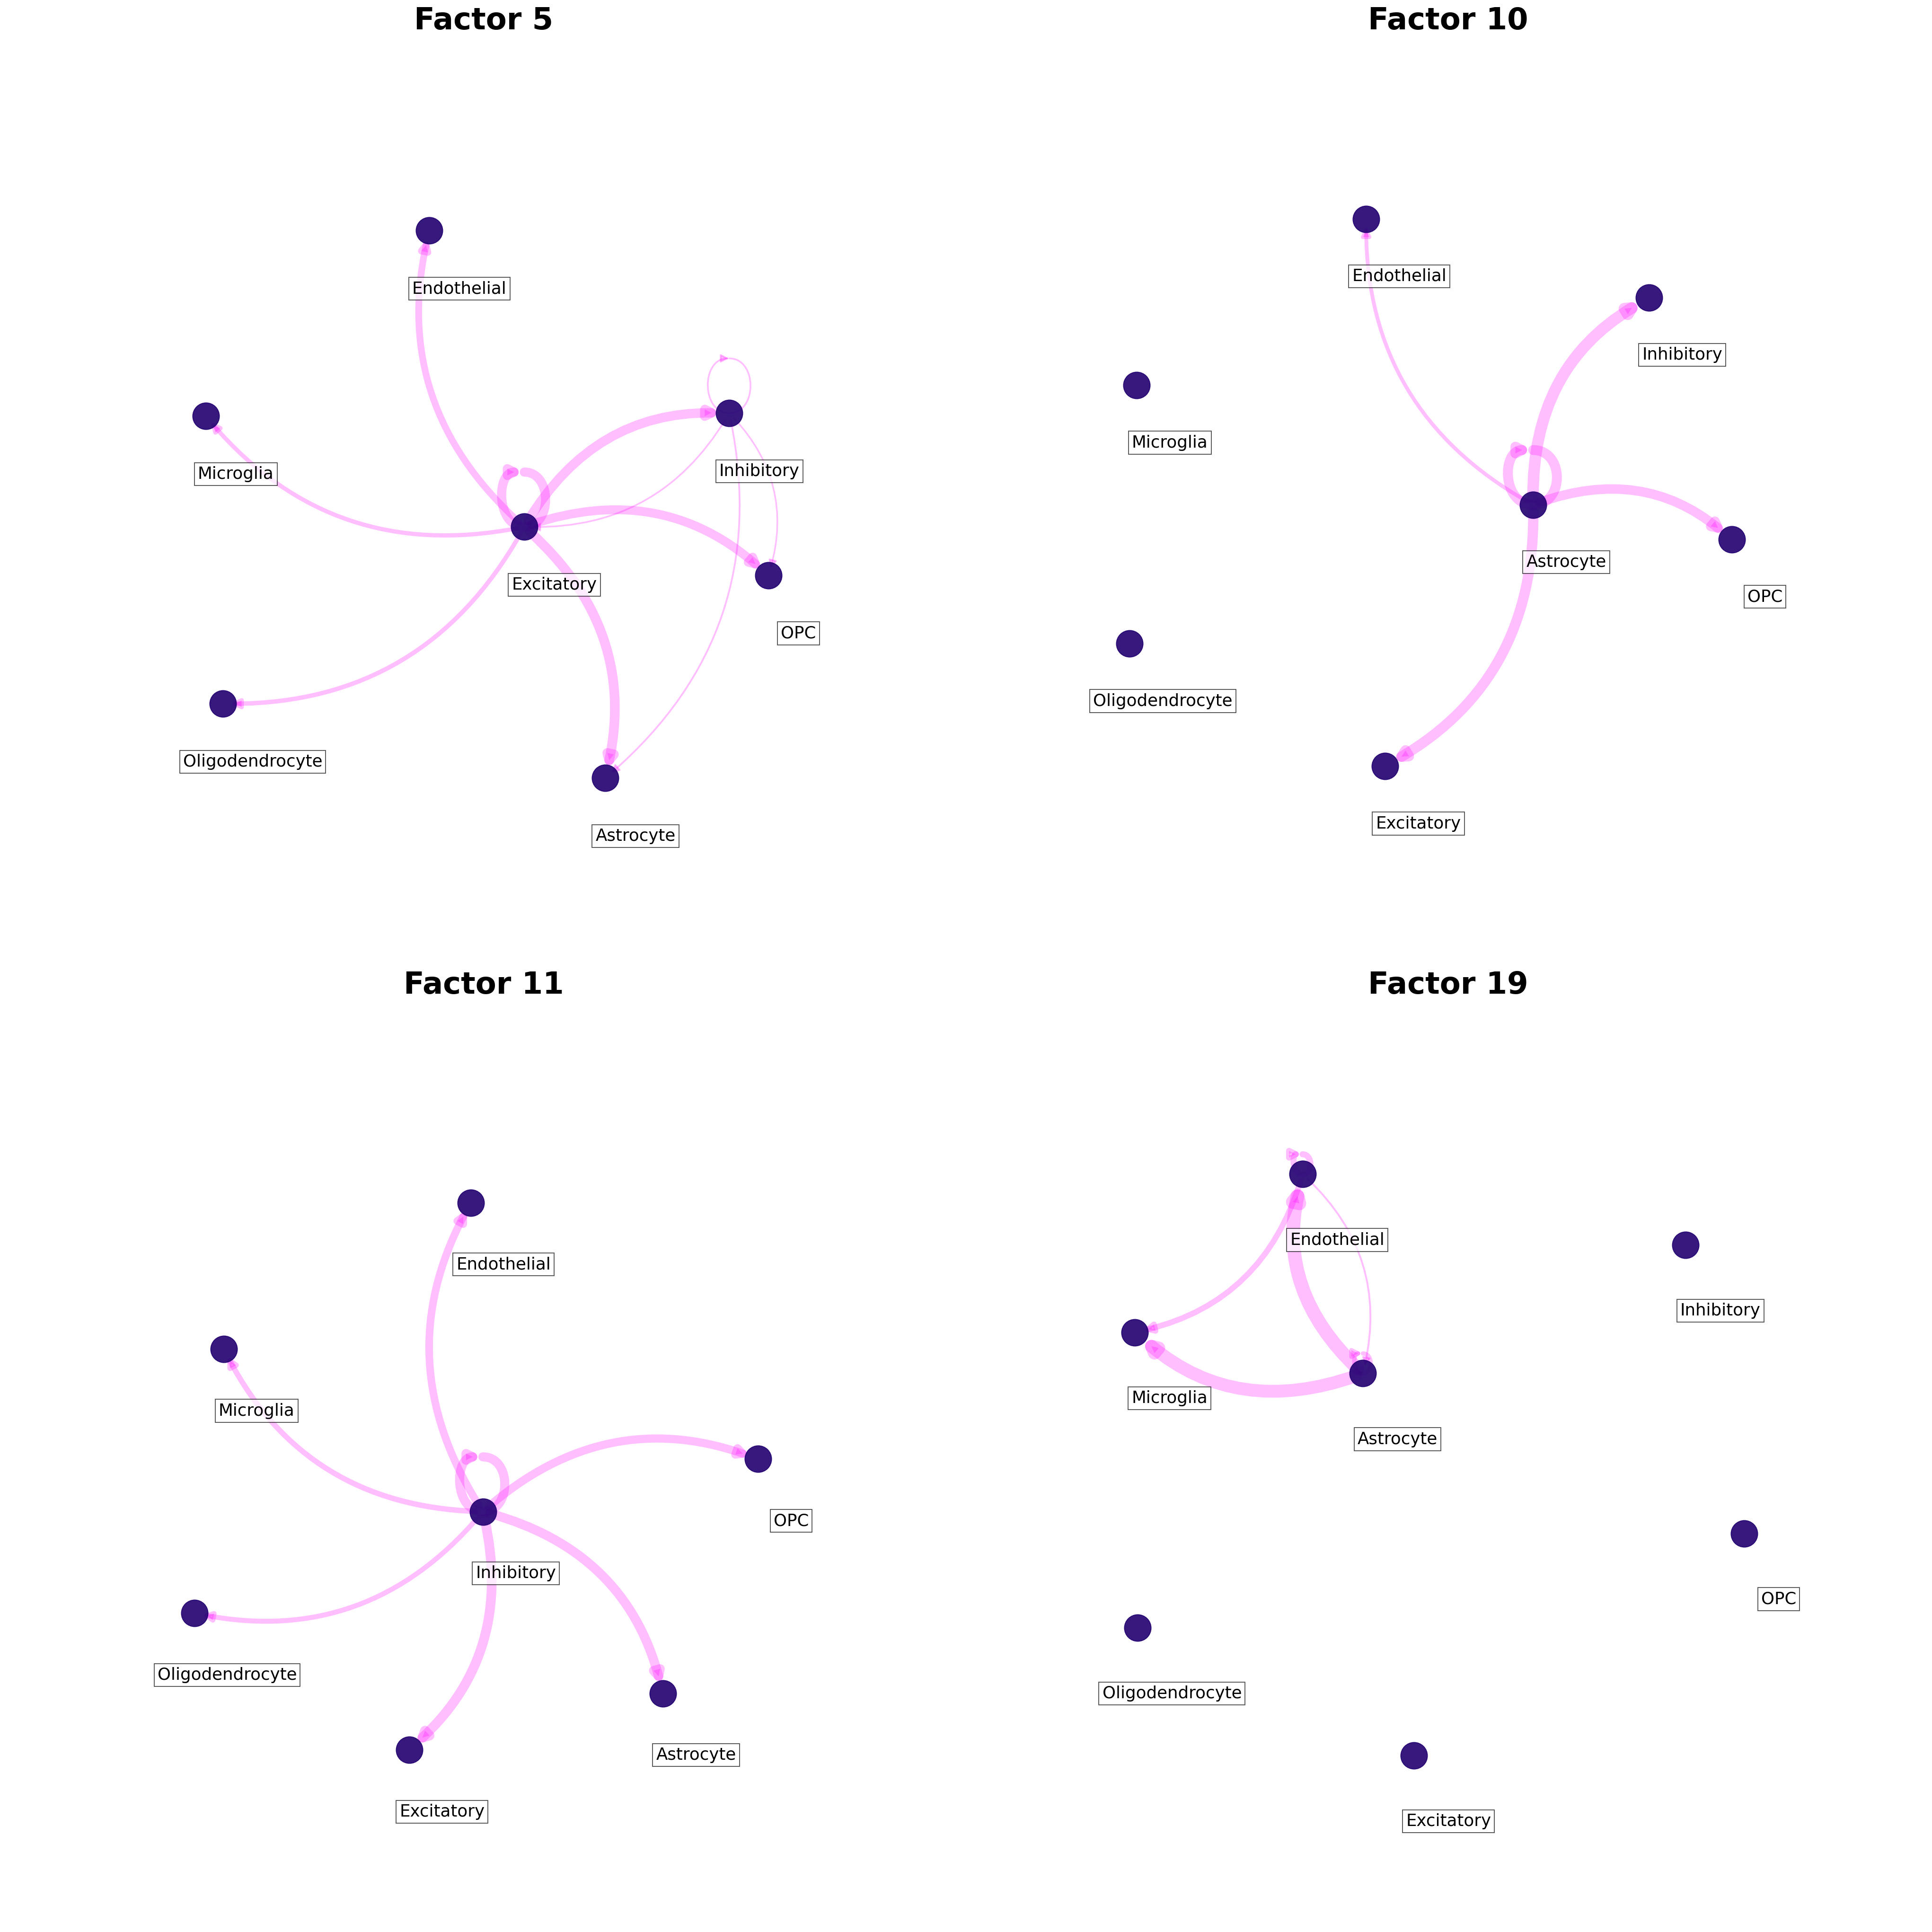

In [32]:
c2c.plotting.ccc_networks_plot(factors,
                               included_factors=['Factor 5', 'Factor 10', 'Factor 11', 'Factor 19'],
                               ccc_threshold=ccc_threshold, # Only important communication
                               nrows=2,
                               panel_size=(16, 16), # This changes the size of each figure panel.
                              )
plt.show()

In [33]:
c2c.analysis.tensor_downstream.compute_gini_coefficients(factors,
                                                         sender_label='Sender Cells',
                                                         receiver_label='Receiver Cells'
                                                        )

,Factor,Gini
0,Factor 1,0.784533
1,Factor 10,0.882527
2,Factor 11,0.862574
3,Factor 12,0.889143
4,Factor 13,0.864261
5,Factor 14,0.919141
6,Factor 15,0.747273
7,Factor 16,0.820278
8,Factor 17,0.823067
9,Factor 18,0.862434


In [35]:
# Generate color by ASD condition for each sample
condition_colors = c2c.plotting.aesthetics.get_colors_from_labels(['no', 'early', 'late'], cmap='viridis')

# Map these colors to each sample name
color_dict = {k : condition_colors[v] for k, v in context_dict.items()}

# Generate a dataframe used as input for the clustermap
col_colors = pd.Series(color_dict)
col_colors = col_colors.to_frame()
col_colors.columns = ['Category']

In [36]:
col_colors.head()

,Category
H21.33.005,"(0.190631, 0.407061, 0.556089, 1.0)"
H20.33.020,"(0.20803, 0.718701, 0.472873, 1.0)"
H21.33.003,"(0.267004, 0.004874, 0.329415, 1.0)"
H20.33.044,"(0.267004, 0.004874, 0.329415, 1.0)"
H21.33.004,"(0.267004, 0.004874, 0.329415, 1.0)"


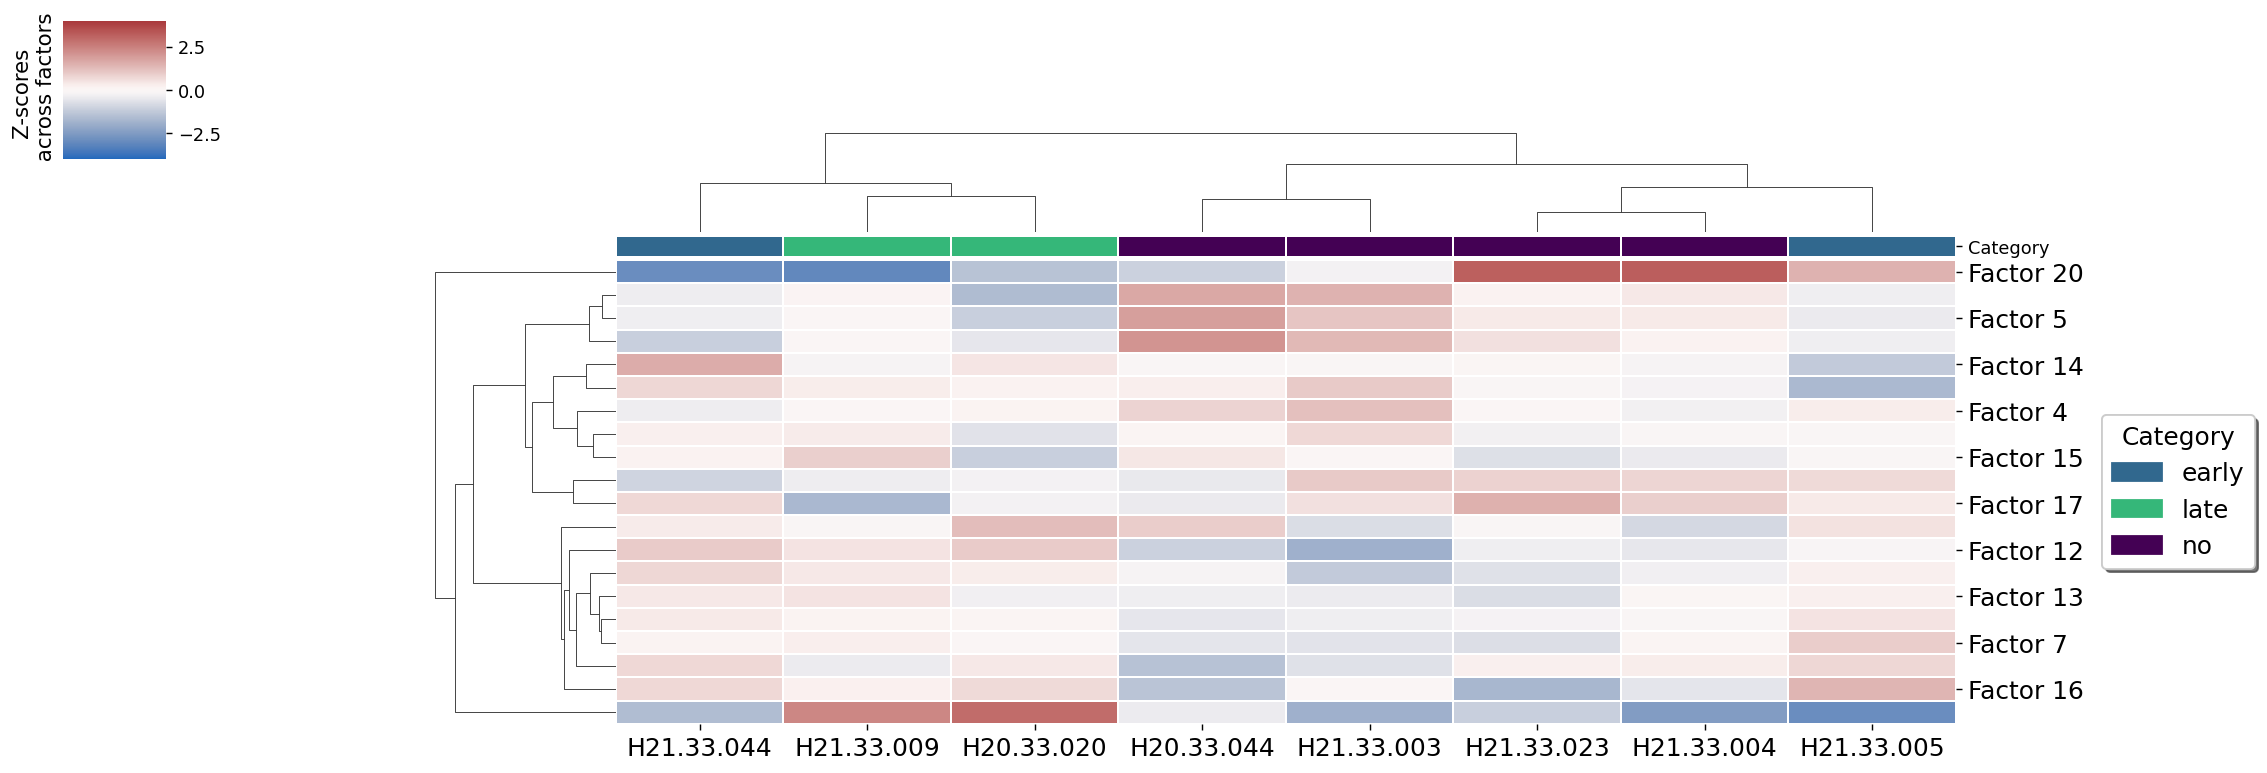

In [37]:
sample_cm = c2c.plotting.loading_clustermap(factors['Contexts'],
                                            use_zscore=True,
                                            col_colors=col_colors, # Change this to color by other properties
                                            figsize=(16, 6),
                                            dendrogram_ratio=0.3,
                                            cbar_fontsize=12,
                                            tick_fontsize=14,
                                            # filename=output_folder + 'Clustermap-Factor-specific-Contexts.svg'
                                           )

#Insert legend
plt.sca(sample_cm.ax_heatmap)
legend = c2c.plotting.aesthetics.generate_legend(color_dict=condition_colors,
                                                 bbox_to_anchor=(1.1, 0.5), # Position of the legend (X, Y)
                                                 title='Category'
                                                )

plt.show()

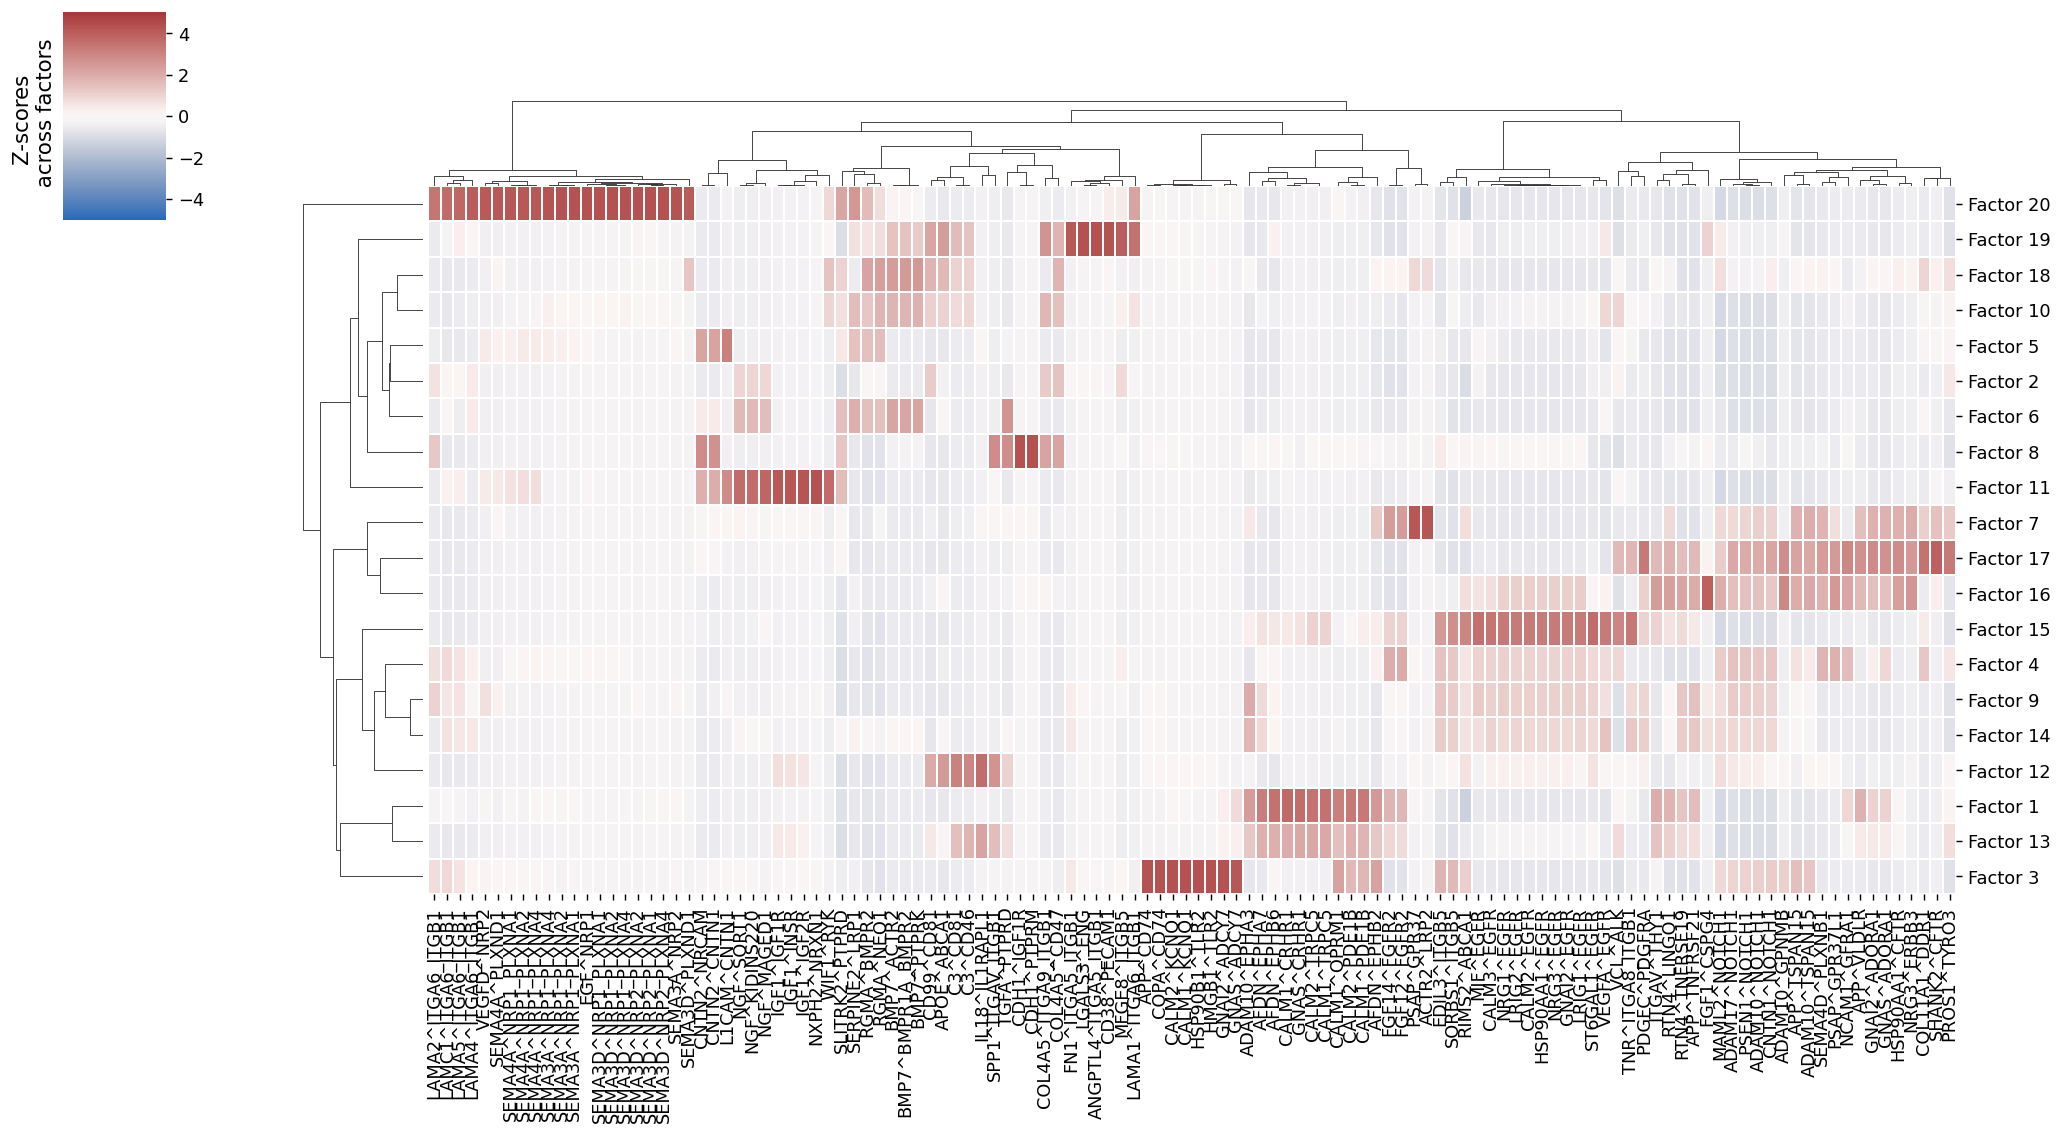

In [38]:
lr_cm = c2c.plotting.loading_clustermap(factors['Ligand-Receptor Pairs'],
                                        loading_threshold=0.1, # To consider only top LRs
                                        use_zscore=True,
                                        figsize=(16, 9),
                                        #filename=output_folder + 'Clustermap-Factor-specific-LRs.svg'
                                       )
plt.show()

In [87]:
pathway_per_gene = defaultdict(set)
with open('../data/pathway_databases/GO_Biological_Process_2018.txt', 'rb') as f:
    for i, line in enumerate(f):
        l = line.decode("utf-8").split('\t')
        l[-1] = l[-1].replace('\n', '')
        l = [pw for pw in l if ('http' not in pw)] # Remove website info
        for gene in l[1:]:
            pathway_per_gene[gene] = pathway_per_gene[gene].union(set([l[0]]))

In [88]:
lr_pairs = pd.read_csv('https://raw.githubusercontent.com/LewisLabUCSD/Ligand-Receptor-Pairs/master/Human/Human-2020-Jin-LR-pairs.csv')
lr_pairs = lr_pairs.astype(str)

In [89]:
# If the LR db include protein complexes. 
# This is the character separating members
complex_sep = '&' 

# Dictionary to save the LR interaction (key) and the annotated pathways (values).
pathway_sets = defaultdict(set)

# Iterate through the interactions in the LR DB.
for idx, row in lr_pairs.iterrows():
    lr_label = row['interaction_symbol']
    lr = lr_label.split('^')
    
    # Gene members of the ligand and the receptor in the LR pair
    if complex_sep is None:
        ligands = [lr[0]]
        receptors = [lr[1]]
    else:
        ligands = lr[0].split(complex_sep)
        receptors = lr[1].split(complex_sep)
    
    # Find pathways associated with all members of the ligand
    for i, ligand in enumerate(ligands):
        if i == 0:
            ligand_pathways = pathway_per_gene[ligand]
        else:
            ligand_pathways = ligand_pathways.intersection(pathway_per_gene[ligand])
            
    # Find pathways associated with all members of the receptor
    for i, receptor in enumerate(receptors):
        if i == 0:
            receptor_pathways = pathway_per_gene[receptor]
        else:
            receptor_pathways = receptor_pathways.intersection(pathway_per_gene[receptor])

    # Keep only pathways that are in both ligand and receptor.
    lr_pathways = ligand_pathways.intersection(receptor_pathways)
    for p in lr_pathways:
        pathway_sets[p] = pathway_sets[p].union([lr_label])

In [90]:
K=15

lr_set = defaultdict(set)
    
for k, v in pathway_sets.items():
    if len(v) >= K:
        lr_set[k] = v

In [91]:
len(lr_set)

87

In [92]:
weight = 1
min_size = 15
permutations = 999
significance_threshold = 0.05

In [93]:
loadings = factors['Ligand-Receptor Pairs'].reset_index()

TypeError: list indices must be integers or slices, not str

In [94]:
import gseapy

for factor in loadings.columns[1:]:
    # Rank LR pairs of each factor by their respective loadings
    test = loadings[['index', factor]]
    test.columns = [0, 1]
    test = test.sort_values(by=1, ascending=False)
    test.reset_index(drop=True, inplace=True)

    # RUN GSEA
    gseapy.prerank(rnk=test,
                   gene_sets=lr_set,
                   min_size=min_size,
                   weighted_score_type=weight,
                   processes=6,
                   permutation_num=permutations, # reduce number to speed up testing
                   outdir='../results/ad_vs_no/'+factor.split()[0]+'_'+factor.split()[1], format='png',
                   seed=6)

/var/folders/c1/8tpkntr176v0pt5_bk6zhrp40000gn/T/ipykernel_3802/224266313.py:11: DeprecationWarning: processes is deprecated; use threads
/var/folders/c1/8tpkntr176v0pt5_bk6zhrp40000gn/T/ipykernel_3802/224266313.py:11: DeprecationWarning: processes is deprecated; use threads
/var/folders/c1/8tpkntr176v0pt5_bk6zhrp40000gn/T/ipykernel_3802/224266313.py:11: DeprecationWarning: processes is deprecated; use threads
/var/folders/c1/8tpkntr176v0pt5_bk6zhrp40000gn/T/ipykernel_3802/224266313.py:11: DeprecationWarning: processes is deprecated; use threads
/var/folders/c1/8tpkntr176v0pt5_bk6zhrp40000gn/T/ipykernel_3802/224266313.py:11: DeprecationWarning: processes is deprecated; use threads
/var/folders/c1/8tpkntr176v0pt5_bk6zhrp40000gn/T/ipykernel_3802/224266313.py:11: DeprecationWarning: processes is deprecated; use threads
/var/folders/c1/8tpkntr176v0pt5_bk6zhrp40000gn/T/ipykernel_3802/224266313.py:11: DeprecationWarning: processes is deprecated; use threads
/var/folders/c1/8tpkntr176v0pt5_bk

In [95]:

pvals = []
terms = []
factors = []
nes = []
for factor in loadings.columns[1:]:
    p_report = pd.read_csv('../results/ad_vs_no/'+factor.split()[0]+'_'+factor.split()[1] + '/gseapy.gene_set.prerank.report.csv')
    pval = p_report['NOM p-val'].values.tolist()
    pvals.extend(pval)
    terms.extend(p_report.Term.values.tolist())
    factors.extend([factor] * len(pval))
    nes.extend(p_report['NES'].values.tolist())
pval_df = pd.DataFrame(np.asarray([factors, terms, nes, pvals]).T, columns=['Factor', 'Term', 'NES', 'P-value'])
pval_df = pval_df.loc[pval_df['P-value'] != 'nan']
pval_df['P-value'] = pd.to_numeric(pval_df['P-value'])
pval_df['P-value'] = pval_df['P-value'].replace(0., 1./(permutations+1))
pval_df['NES'] = pd.to_numeric(pval_df['NES'])

In [96]:
from statsmodels.stats.multitest import fdrcorrection

pval_df['Adj. P-value'] = fdrcorrection(pval_df['P-value'].values,
                                        alpha=significance_threshold)[1]

In [97]:
pval_df.loc[(pval_df['Adj. P-value'] < significance_threshold) & (pval_df['NES'] > 0.)]

,Factor,Term,NES,P-value,Adj. P-value
0,Factor 1,extracellular matrix organization (GO:0030198),1.449841,0.001000,0.013731
1,Factor 1,MAPK cascade (GO:0000165),1.363997,0.001000,0.013731
2,Factor 1,regulation of protein kinase B signaling (GO:0...,1.363077,0.001000,0.013731
3,Factor 1,positive regulation of protein kinase B signal...,1.363077,0.001000,0.013731
4,Factor 1,cellular response to fibroblast growth factor ...,1.353747,0.001000,0.013731
...,...,...,...,...,...
444,Factor 13,ephrin receptor signaling pathway (GO:0048013),1.178559,0.004004,0.042941
481,Factor 14,non-canonical Wnt signaling pathway (GO:0035567),1.360278,0.001001,0.013731
482,Factor 14,negative regulation of apoptotic process (GO:0...,1.340289,0.001000,0.013731
483,Factor 14,Wnt signaling pathway (GO:0016055),1.315516,0.002002,0.025991


In [98]:
pval_df.loc[(pval_df['Adj. P-value'] < significance_threshold) & (pval_df['NES'] < 0.)]

,Factor,Term,NES,P-value,Adj. P-value
414,Factor 12,nervous system development (GO:0007399),-1.037026,0.001,0.013731


In [99]:
pval_df.to_excel('../results/ad_vs_no/'+ 'GSEA-Adj-Pvals.xlsx')

In [100]:
pval_pivot = pval_df.pivot(index="Term", columns="Factor", values="Adj. P-value").fillna(1.)
scores = pval_df.pivot(index="Term", columns="Factor", values="NES").fillna(0)

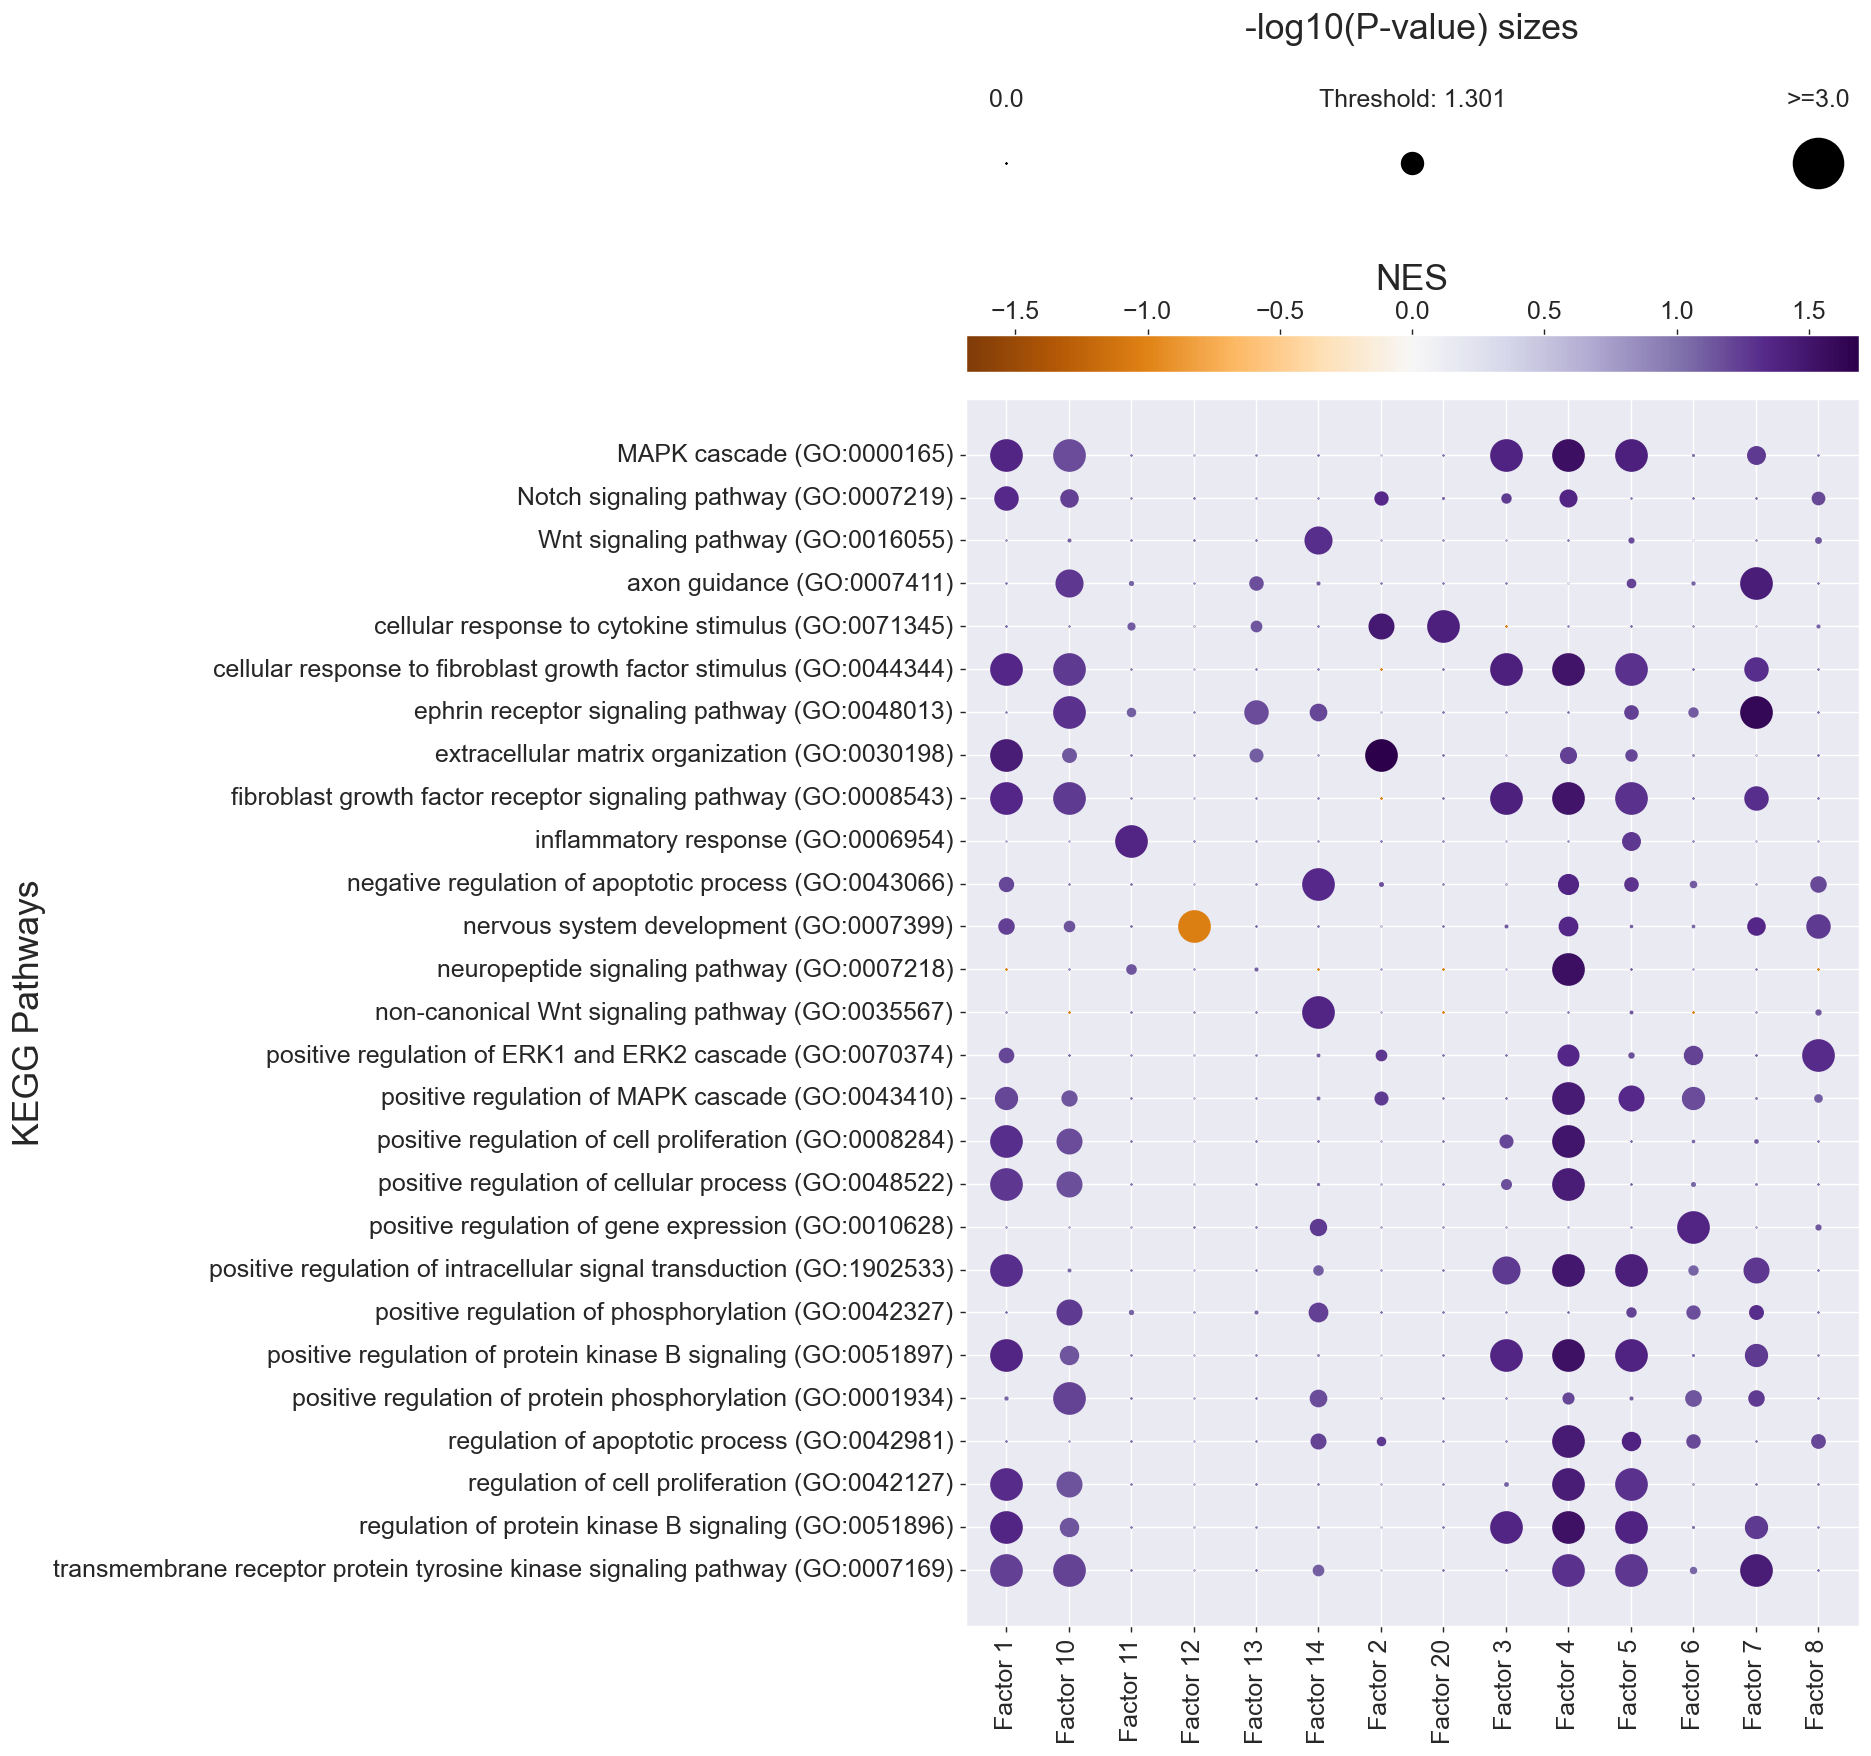

In [101]:
with sb.axes_style("darkgrid"):
    dotplot = c2c.plotting.pval_plot.generate_dot_plot(pval_df=pval_pivot,
                                                       score_df=scores,
                                                       significance=significance_threshold,
                                                       xlabel='',
                                                       ylabel='KEGG Pathways',
                                                       cbar_title='NES',
                                                       cmap='PuOr',
                                                       figsize=(9,16),
                                                       label_size=20,
                                                       title_size=20,
                                                       tick_size=14,
                                                       filename='../results/ad_vs_no' + '/GSEA-Dotplot.svg'
                                                      )
    plt.show()

This dot plot indicates the pathways or LR sets enriched/depleted (depending on the color) in each of the factors. 


The size of the circles indicates whether they are significant. The threshold size is for the significance threshold (usually P < 0.05).